**NAMES:**<br>
**CARLOS MIGUEL K. JAKOSALEM**<br>
**FRANCIS RALE M. ABRENICA**

Step 1: Import Required Libraries
In this step, we import all the necessary Python libraries for data handling, plotting, clustering, and statistical analysis. We also disable warnings to keep the output clean.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from statsmodels.distributions.empirical_distribution import ECDF

import warnings
warnings.filterwarnings('ignore')


Step 2: Load and Preprocess the Full Dataset
This step reads the CSV file (med_events.csv), converts the DATE column to datetime format, and sorts the data by PATIENT_ID and DATE to ensure that events are in chronological order.

In [ ]:

df = pd.read_csv('med_events.csv')

# Convert the DATE column to datetime and sort by PATIENT_ID and DATE.
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values(by=['PATIENT_ID', 'DATE'])

print("First 5 rows of the full dataset:")
display(df.head())

print("\nAvailable columns:")
print(df.columns.tolist())

print("\nSummary statistics:")
display(df.describe())



First 5 rows of the full dataset:


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30



Available columns:
['PATIENT_ID', 'DATE', 'PERDAY', 'CATEGORY', 'DURATION']

Summary statistics:


,PATIENT_ID,DATE,PERDAY,DURATION
count,1080.000000,1080,1080.000000,1080.00000
mean,50.934259,2038-01-29 22:02:40,3.762963,47.37963
min,1.000000,2030-09-06 00:00:00,2.000000,20.00000
25%,24.000000,2035-06-03 06:00:00,2.000000,30.00000
50%,51.500000,2037-09-03 12:00:00,4.000000,50.00000
75%,78.000000,2041-05-05 00:00:00,4.000000,50.00000
max,100.000000,2044-09-03 00:00:00,20.000000,150.00000
std,29.999542,NaN,2.139552,22.08091


Step 3: Calculate Refill Intervals (Full Dataset)
For each patient, we compute the time difference in days between consecutive medication events. These differences are stored in a new column named intervals. We then remove the first event for each patient (which results in a NaN value).

In [ ]:
# For each patient, compute the time difference (in days) between consecutive events.
df['intervals'] = df.groupby('PATIENT_ID')['DATE'].diff().dt.days

# Remove rows with NaN intervals (i.e. the first event for each patient).
df = df.dropna(subset=['intervals'])
intervals_data = df[['intervals']].copy()

print("\nSample of computed refill intervals:")
display(intervals_data.head(10))



Sample of computed refill intervals:


,intervals
1,69.0
2,30.0
3,14.0
4,57.0
5,3.0
6,38.0
7,57.0
8,20.0
9,28.0
10,31.0


Step 4: Extra Visualizations for Refill Intervals
We generate additional plots to explore the distribution of refill intervals:

Density Plot: Uses a KDE (Kernel Density Estimate) to show the distribution.
ECDF Plot: Plots the empirical cumulative distribution function to visualize the cumulative proportion of intervals.

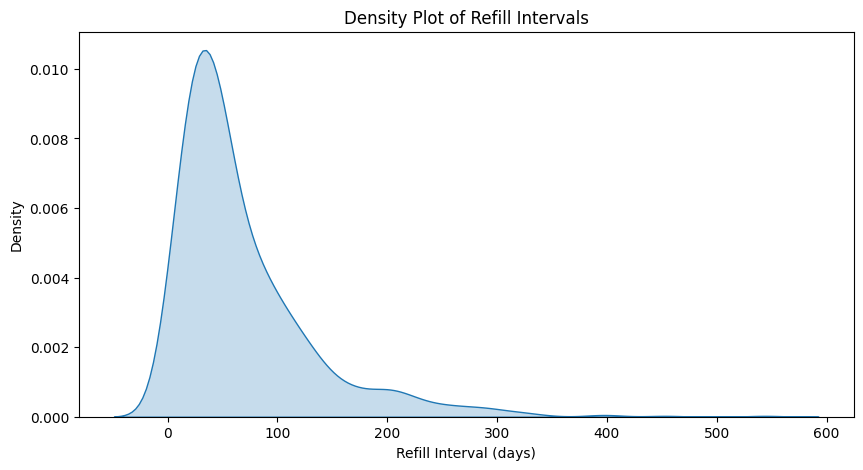

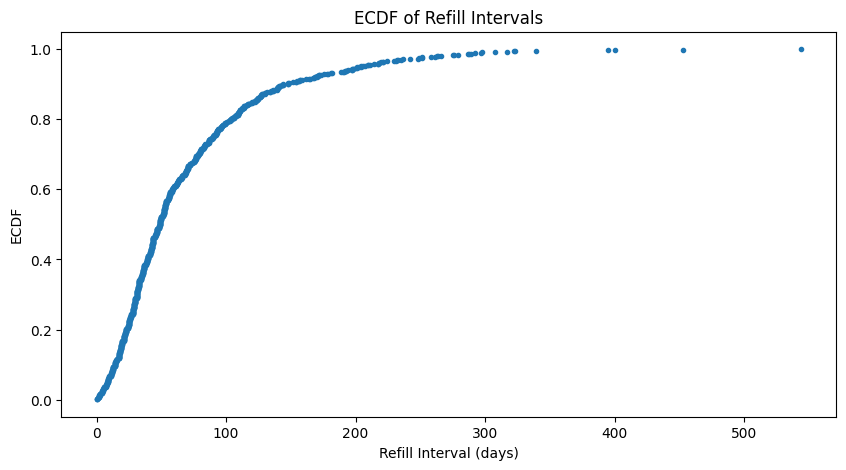

In [ ]:
# 4.1 Density Plot: Visualize the distribution of refill intervals.
plt.figure(figsize=(10, 5))
sns.kdeplot(intervals_data['intervals'], shade=True)
plt.title("Density Plot of Refill Intervals")
plt.xlabel("Refill Interval (days)")
plt.ylabel("Density")
plt.show()

# 4.2 ECDF Plot: Plot the empirical cumulative distribution function.
ecdf = ECDF(intervals_data['intervals'])
plt.figure(figsize=(10, 5))
plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.title("ECDF of Refill Intervals")
plt.xlabel("Refill Interval (days)")
plt.ylabel("ECDF")
plt.show()


Step 5: Build ECDF and Filter to First 80% of Intervals
In this step, we sort the refill intervals, calculate the ECDF values, and determine the cutoff corresponding to the 80th percentile. Only intervals below or equal to this cutoff are retained for further analysis.

In [ ]:
# Sort intervals and compute the empirical cumulative distribution values.
sorted_intervals = np.sort(intervals_data['intervals'].values)
n = len(sorted_intervals)
ecdf_y = np.arange(1, n + 1) / n

# Determine the cutoff value corresponding to the 80th percentile.
cutoff_index = np.searchsorted(ecdf_y, 0.8)
interval_cutoff_value = sorted_intervals[cutoff_index]
print(f"\n80% cutoff value for 'intervals': {interval_cutoff_value:.2f} days")

# Keep only the lower 80% of the intervals.
intervals_filtered = intervals_data[intervals_data['intervals'] <= interval_cutoff_value].copy()
print(f"\nTotal intervals: {len(intervals_data)}")
print(f"Intervals after filtering (<=80th percentile): {len(intervals_filtered)}")



80% cutoff value for 'intervals': 104.00 days

Total intervals: 980
Intervals after filtering (<=80th percentile): 785


Step 6: Standardize the Filtered Intervals
Before clustering, we standardize the filtered refill intervals using a StandardScaler. This normalization step is crucial for many clustering algorithms.

In [ ]:
scaler = StandardScaler()
X_sample = scaler.fit_transform(intervals_filtered[['intervals']])


Step 7: Silhouette Analysis for K-Means Clustering
We perform silhouette analysis to determine the optimal number of clusters for K-Means. The silhouette score is calculated for cluster numbers ranging from 2 to 10, and a plot is generated to visualize the scores. The number of clusters with the highest score is selected

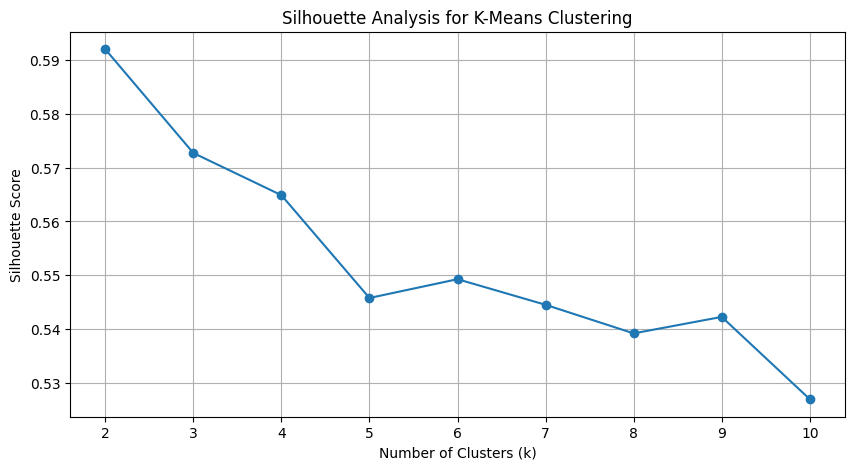


Optimal number of clusters (K-Means): 2 (Silhouette Score: 0.592)


In [ ]:
range_n_clusters = range(2, 11)
silhouette_scores = []

for k in range_n_clusters:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels_temp)
    silhouette_scores.append(score)

# Plot silhouette scores versus number of clusters.
plt.figure(figsize=(10, 5))
plt.plot(list(range_n_clusters), silhouette_scores, marker='o')
plt.title("Silhouette Analysis for K-Means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(list(range_n_clusters))
plt.grid(True)
plt.show()

# Determine the optimal number of clusters.
best_k = range_n_clusters[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\nOptimal number of clusters (K-Means): {best_k} (Silhouette Score: {best_score:.3f})")


Step 8: Apply K-Means Clustering and Compute Cluster Medians
With the optimal number of clusters determined from the silhouette analysis, we apply K-Means clustering to the standardized data. Then, for each cluster, we compute the median refill interval.

In [ ]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
intervals_filtered['cluster_kmeans'] = kmeans_final.fit_predict(X_sample)

# Compute median refill interval for each K-Means cluster.
cluster_medians = []
for c in range(best_k):
    cluster_vals = intervals_filtered.loc[intervals_filtered['cluster_kmeans'] == c, 'intervals'].values
    median_val = np.median(cluster_vals) if len(cluster_vals) > 0 else np.nan
    cluster_medians.append((c, median_val))
cluster_medians_df = pd.DataFrame(cluster_medians, columns=['cluster', 'median_interval'])
print("\nK-Means Cluster Medians:")
display(cluster_medians_df)



K-Means Cluster Medians:


,cluster,median_interval
0,0,69.0
1,1,28.0


Step 9: Apply DBSCAN Clustering as an Alternative Method
As an alternative to K-Means, we apply DBSCAN clustering, which does not require specifying the number of clusters. We then compute the median refill interval for each DBSCAN cluster (excluding noise).

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
intervals_filtered['cluster_dbscan'] = dbscan.fit_predict(X_sample)

# Compute median refill intervals for DBSCAN clusters (ignoring noise: label -1).
unique_dbscan = sorted(intervals_filtered['cluster_dbscan'].unique())
cluster_medians_dbscan = []
for c in unique_dbscan:
    if c == -1:
        continue  # Skip noise
    vals = intervals_filtered.loc[intervals_filtered['cluster_dbscan'] == c, 'intervals'].values
    median_val = np.median(vals) if len(vals) > 0 else np.nan
    cluster_medians_dbscan.append((c, median_val))
cluster_medians_dbscan_df = pd.DataFrame(cluster_medians_dbscan, columns=['cluster', 'median_interval_dbscan'])
print("\nDBSCAN Cluster Medians (excluding noise):")
display(cluster_medians_dbscan_df)



DBSCAN Cluster Medians (excluding noise):


,cluster,median_interval_dbscan
0,0,40.0


Step 10: Visualize Clustering Results (Full Dataset)
We visualize the clustering results using boxplots. Two plots are generated side by side:

The first shows the distribution of refill intervals by K-Means clusters.
The second shows the distribution by DBSCAN clusters. Both plots include a horizontal line indicating the 80% cutoff value.

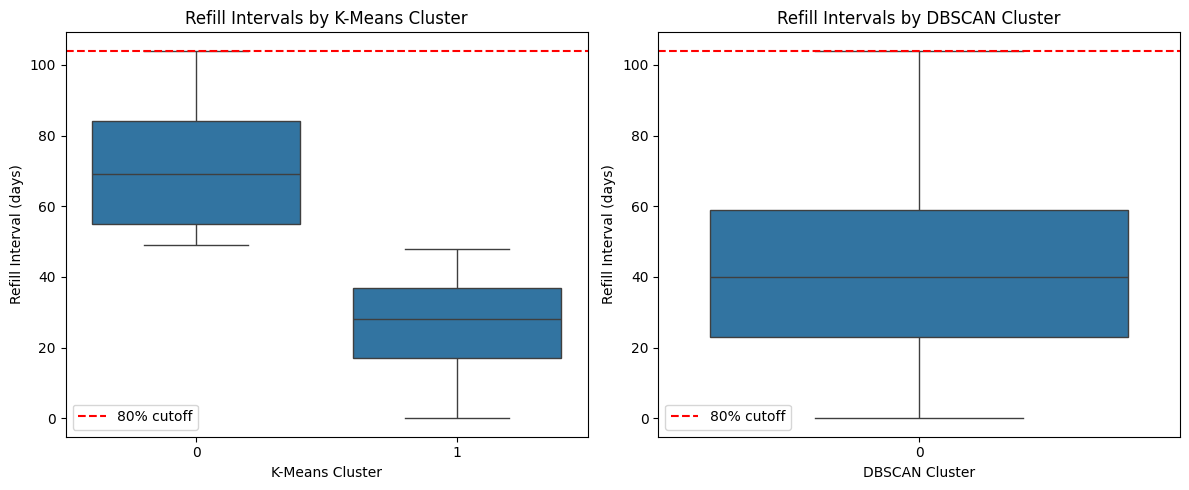

In [ ]:
plt.figure(figsize=(12, 5))

# Boxplot: Refill Intervals by K-Means Clusters.
plt.subplot(1, 2, 1)
sns.boxplot(x='cluster_kmeans', y='intervals', data=intervals_filtered)
plt.axhline(y=interval_cutoff_value, color='red', linestyle='--', label='80% cutoff')
plt.title("Refill Intervals by K-Means Cluster")
plt.xlabel("K-Means Cluster")
plt.ylabel("Refill Interval (days)")
plt.legend()

# Boxplot: Refill Intervals by DBSCAN Clusters.
plt.subplot(1, 2, 2)
sns.boxplot(x='cluster_dbscan', y='intervals', data=intervals_filtered)
plt.axhline(y=interval_cutoff_value, color='red', linestyle='--', label='80% cutoff')
plt.title("Refill Intervals by DBSCAN Cluster")
plt.xlabel("DBSCAN Cluster")
plt.ylabel("Refill Interval (days)")
plt.legend()

plt.tight_layout()
plt.show()


Step 11: Boxplot of Refill Intervals by Prescription Order (Full Dataset)
In this step, we calculate the prescription order (the sequential number of events per patient) and determine the dominant K-Means cluster (the one with the most records). We then plot a boxplot of refill intervals by prescription order, overlaying a horizontal line that represents the dominant cluster’s median refill interval.

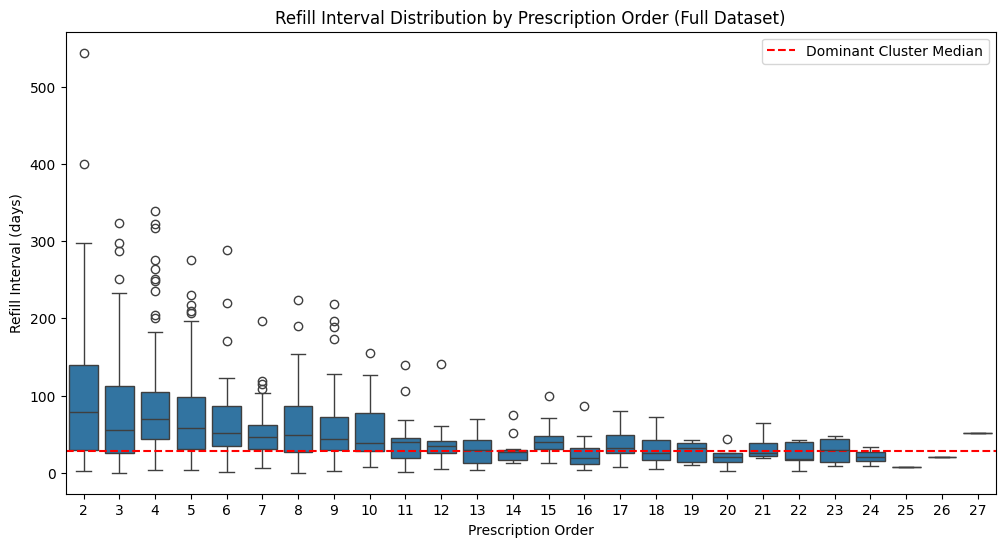

In [ ]:
# Compute the prescription order (i.e. event number per patient).
df['prescription_order'] = df.groupby('PATIENT_ID').cumcount() + 1

# Identify the dominant K-Means cluster (with the most records) and get its median.
dominant_cluster = intervals_filtered['cluster_kmeans'].value_counts().idxmax()
dominant_median = intervals_filtered.loc[intervals_filtered['cluster_kmeans'] == dominant_cluster, 'intervals'].median()

# For visualization, assign the dominant median as a new column.
df['assigned_duration'] = dominant_median

plt.figure(figsize=(12, 6))
sns.boxplot(x='prescription_order', y='intervals', data=df[df['prescription_order'] >= 2])
plt.axhline(y=dominant_median, color='r', linestyle='--', label='Dominant Cluster Median')
plt.title("Refill Interval Distribution by Prescription Order (Full Dataset)")
plt.xlabel("Prescription Order")
plt.ylabel("Refill Interval (days)")
plt.legend()
plt.show()


Step 12: Define Functions for Medication-Specific Duration Distributions
In this section, we define a set of functions to:

Load and preprocess data for a specific medication.
Apply ECDF filtering.
Determine the optimal number of clusters using either K-Means (with silhouette analysis) or GMM (with BIC).
Perform clustering.
Assign the dominant cluster’s median event interval.
Plot the duration distribution by prescription order.
These functions will be used later to generate plots for specific medications (e.g., medA and medB).

In [ ]:
def load_and_preprocess_by_med(file_path, medication):
    """Load CSV, filter by medication category, and compute event intervals."""
    df_med = pd.read_csv(file_path)
    df_med['DATE'] = pd.to_datetime(df_med['DATE'])
    df_med = df_med[df_med['CATEGORY'] == medication].sort_values(['PATIENT_ID', 'DATE'])
    df_med['prev_DATE'] = df_med.groupby('PATIENT_ID')['DATE'].shift(1)
    df_med = df_med.dropna(subset=['prev_DATE'])
    df_med['event_interval'] = (df_med['DATE'] - df_med['prev_DATE']).dt.days
    return df_med

def compute_ecdf_filter(event_intervals, ecdf_threshold=0.8):
    """Compute the ECDF and return filtered values (<= threshold)."""
    ecdf_inst = ECDF(event_intervals)
    mask = ecdf_inst.y <= ecdf_threshold
    x_filtered = ecdf_inst.x[mask]
    x_filtered = x_filtered[np.isfinite(x_filtered)]
    x_filtered = x_filtered[~np.isnan(x_filtered)]
    return x_filtered

def find_optimal_clusters_kmeans(data):
    """Determine optimal clusters using Silhouette Score (K-Means)."""
    X = data.reshape(-1, 1)
    silhouette_scores = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
    optimal_n = np.argmax(silhouette_scores) + 2  # clusters start at 2
    return optimal_n

def find_optimal_clusters_gmm(data):
    """Determine optimal clusters using BIC (GMM)."""
    X = data.reshape(-1, 1)
    bic = []
    from sklearn.mixture import GaussianMixture
    for n_components in range(1, 11):
        gmm = GaussianMixture(n_components=n_components, random_state=1234)
        gmm.fit(X)
        bic.append(gmm.bic(X))
    optimal_n = np.argmin(bic) + 1  # components start at 1
    return optimal_n

def apply_clustering(data, n_clusters, algorithm='kmeans'):
    """Apply the chosen clustering algorithm (K-Means or GMM) and return cluster labels."""
    X = data.reshape(-1, 1)
    if algorithm == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=1234)
    elif algorithm == 'gmm':
        from sklearn.mixture import GaussianMixture
        model = GaussianMixture(n_components=n_clusters, random_state=1234)
    labels = model.fit_predict(X)
    return labels

def assign_median_duration(df_med, labels, x_filtered):
    """Assign the dominant cluster’s median duration to all records."""
    temp_df = pd.DataFrame({'event_interval': x_filtered, 'cluster': labels})
    cluster_summary = temp_df.groupby('cluster')['event_interval'].agg(['count', 'median'])
    dominant_cluster = cluster_summary['count'].idxmax()
    median_duration = cluster_summary.loc[dominant_cluster, 'median']
    df_med['assigned_duration'] = median_duration
    return df_med

def plot_duration_distribution(df_med, title):
    """Plot boxplot of event intervals by prescription order with the assigned median."""
    df_med['prescription_order'] = df_med.groupby('PATIENT_ID').cumcount() + 1
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='prescription_order', y='event_interval', data=df_med[df_med['prescription_order'] >= 2])
    plt.axhline(y=df_med['assigned_duration'].median(), color='r', linestyle='--', label='Median Duration')
    plt.title(title)
    plt.xlabel("Prescription Order")
    plt.ylabel("Event Interval (days)")
    plt.legend()
    plt.show()

def sessa_empirical_estimator_med(file_path, medication, algorithm='kmeans'):
    """
    For a given medication, preprocess data, apply ECDF filtering, determine optimal clusters
    (using either K-Means or GMM), assign the dominant cluster’s median duration, and plot the
    duration distribution by prescription order.
    """
    df_med = load_and_preprocess_by_med(file_path, medication)
    x_filtered = compute_ecdf_filter(df_med['event_interval'].values)
    if algorithm == 'kmeans':
        optimal_n = find_optimal_clusters_kmeans(x_filtered)
    elif algorithm == 'gmm':
        optimal_n = find_optimal_clusters_gmm(x_filtered)
    labels = apply_clustering(x_filtered, optimal_n, algorithm)
    df_med = assign_median_duration(df_med, labels, x_filtered)
    plot_duration_distribution(df_med, f'Duration Distribution ({algorithm.upper()}) - {medication}')
    return df_med


Step 13: Plot Duration Distributions for Specific Medications (medA and medB)
Using the functions defined in the previous step, we generate duration distribution plots for specific medications (e.g., medA and medB). We perform the analysis using both K-Means and Gaussian Mixture Models (GMM).

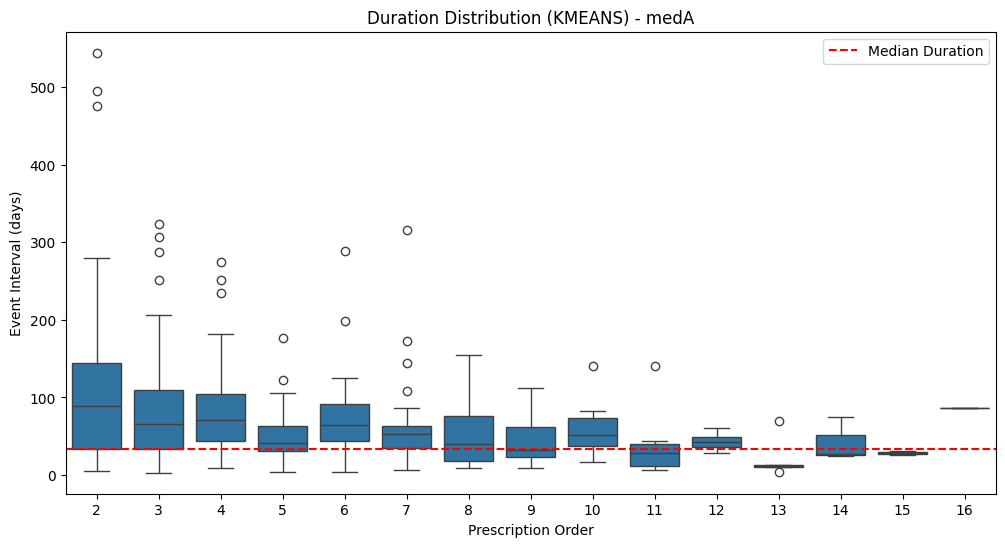

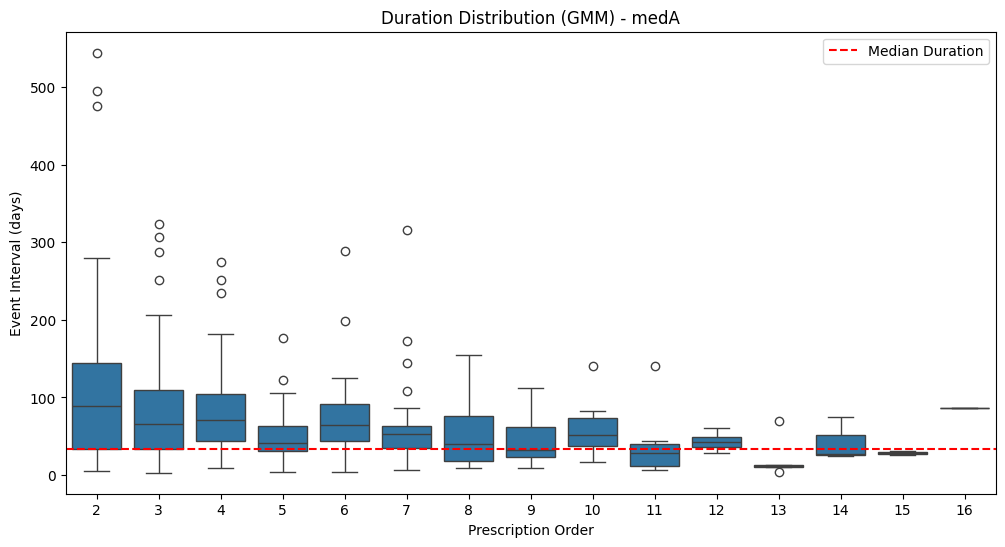

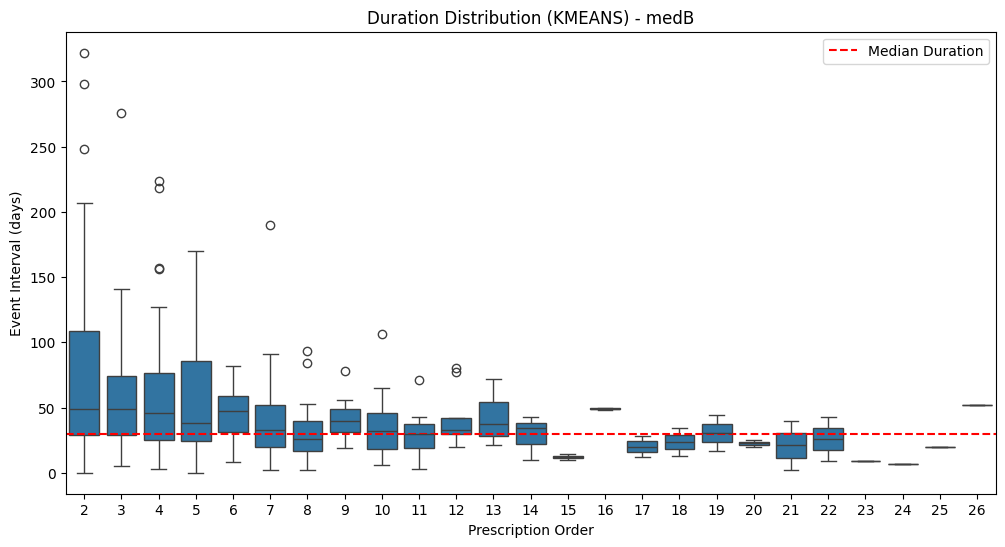

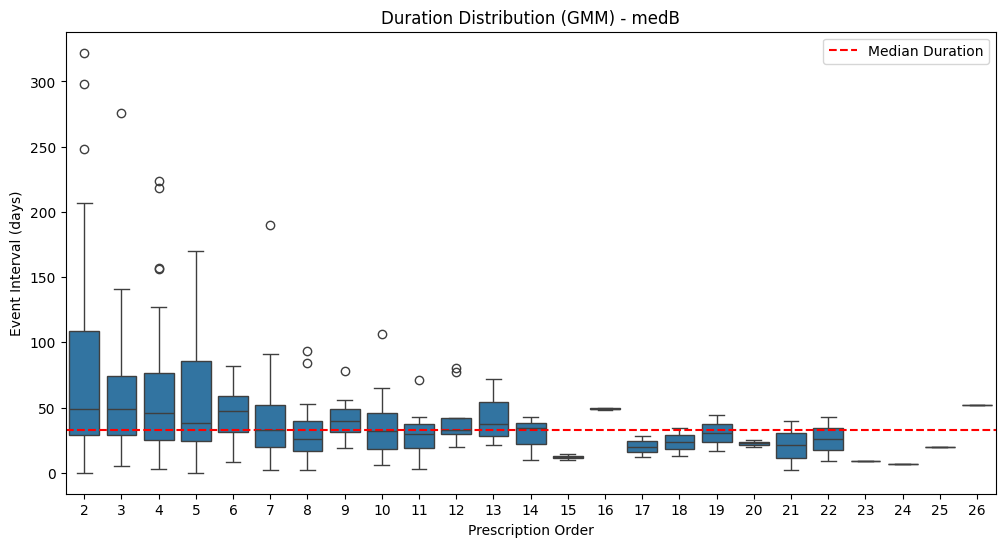

In [ ]:
# For medA using K-Means and GMM
medA_kmeans = sessa_empirical_estimator_med('med_events.csv', 'medA', 'kmeans')
medA_gmm    = sessa_empirical_estimator_med('med_events.csv', 'medA', 'gmm')

# For medB using K-Means and GMM
medB_kmeans = sessa_empirical_estimator_med('med_events.csv', 'medB', 'kmeans')
medB_gmm    = sessa_empirical_estimator_med('med_events.csv', 'medB', 'gmm')


Step 14: Conclusions and Insights
Finally, we print a summary of our findings. This includes details about the filtering (using an ECDF cutoff), the extra visualizations (density, ECDF, silhouette analysis), and the clustering results (K-Means and DBSCAN). Additionally, we summarize the medication-specific duration distribution analysis.

In [ ]:
print("\nCONCLUSIONS:")
print(f"""
1. The full dataset was preprocessed to compute refill intervals, and an ECDF was used to filter out
   the top 20% of long intervals (cutoff: {interval_cutoff_value:.2f} days).
2. Extra visualizations include a density plot, an ECDF plot, and a silhouette analysis plot.
3. Clustering via K-Means (optimal k = {best_k}) and DBSCAN yielded distinct groupings, whose medians
   are displayed above.
4. A boxplot of refill intervals by prescription order (full dataset) highlights the dominant cluster’s
   median ({dominant_median} days).
5. Additionally, for specific medications (medA and medB), duration distributions were plotted using
   both K-Means and GMM, offering further insights into refill behavior.
""")



CONCLUSIONS:

1. The full dataset was preprocessed to compute refill intervals, and an ECDF was used to filter out
   the top 20% of long intervals (cutoff: 104.00 days).
2. Extra visualizations include a density plot, an ECDF plot, and a silhouette analysis plot.
3. Clustering via K-Means (optimal k = 2) and DBSCAN yielded distinct groupings, whose medians
   are displayed above.
4. A boxplot of refill intervals by prescription order (full dataset) highlights the dominant cluster’s
   median (28.0 days).
5. Additionally, for specific medications (medA and medB), duration distributions were plotted using
   both K-Means and GMM, offering further insights into refill behavior.

